<a href="https://colab.research.google.com/github/lorediana/DSIP-PROJECT/blob/main/Data_science_industry_project_e_commerce%20(almost%20final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## E-commerce - Customer Segmentation

A project made in collaboration by:


*   Lavinia Popa
*   Lorena Bara
*   Lucian Anton
*   Mircea Vaman (Chapter 1, Chapter 5 - 5.5 - 5.7, Chapter 6)
*   Rubén Lozano








# 1 Data Preparation

Loading packages

In [ ]:
!pip install pycaret

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
from typing import Dict, List

Mounting the file path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Testing which are the suitable encodings

In [ ]:
'''
from encodings.aliases import aliases
alias_values = set(aliases.values())

for encoding in set(aliases.values()):
    try:
        df = pd.read_csv('/content/drive/MyDrive/data.csv', encoding=encoding)
        print('successful', encoding)
    except:
        pass
'''

"\nfrom encodings.aliases import aliases\nalias_values = set(aliases.values())\n\nfor encoding in set(aliases.values()):\n    try:\n        df = pd.read_csv('/content/drive/MyDrive/data.csv', encoding=encoding)\n        print('successful', encoding)\n    except:\n        pass\n"

Loading the dataset

In [ ]:
dfi = pd.read_csv('/content/drive/MyDrive/data.csv', encoding="ISO-8859-2", dtype={'CustomerID': str,'InvoiceNo': str}, engine='python')
dfi

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680,France


Creating a table of summary

In [ ]:
def tableSummary(dfi):
    print(f"Dataset Shape: {dfi.shape}")
    summary = pd.DataFrame(dfi.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing %'] = 100* np.round(dfi.isnull().sum().values/len(dfi),2)  
    summary['Uniques'] = dfi.nunique().values
    summary['Duplicates'] = dfi.duplicated().values.any()
    summary['First Value'] = dfi.loc[0].values
    summary['Second Value'] = dfi.loc[1].values
    summary['Third Value'] = dfi.loc[2].values
    return summary
dfi_info = tableSummary(dfi)
dfi_info

Dataset Shape: (541909, 8)


,Name,dtypes,Missing %,Uniques,Duplicates,First Value,Second Value,Third Value
0,InvoiceNo,object,0.0,25900,True,536365,536365,536365
1,StockCode,object,0.0,4070,True,85123A,71053,84406B
2,Description,object,0.0,4223,True,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER
3,Quantity,int64,0.0,722,True,6,6,8
4,InvoiceDate,object,0.0,23260,True,12/1/2010 8:26,12/1/2010 8:26,12/1/2010 8:26
5,UnitPrice,float64,0.0,1630,True,2.55,3.39,2.75
6,CustomerID,object,25.0,4372,True,17850,17850,17850
7,Country,object,0.0,38,True,United Kingdom,United Kingdom,United Kingdom


Dropping ```NAs``` and Duplicates

In [ ]:
df1 = dfi.dropna()
df = df1.drop_duplicates()
df_info = tableSummary(df)
df_info

Dataset Shape: (401604, 8)


,Name,dtypes,Missing %,Uniques,Duplicates,First Value,Second Value,Third Value
0,InvoiceNo,object,0.0,22190,False,536365,536365,536365
1,StockCode,object,0.0,3684,False,85123A,71053,84406B
2,Description,object,0.0,3896,False,WHITE HANGING HEART T-LIGHT HOLDER,WHITE METAL LANTERN,CREAM CUPID HEARTS COAT HANGER
3,Quantity,int64,0.0,436,False,6,6,8
4,InvoiceDate,object,0.0,20460,False,12/1/2010 8:26,12/1/2010 8:26,12/1/2010 8:26
5,UnitPrice,float64,0.0,620,False,2.55,3.39,2.75
6,CustomerID,object,0.0,4372,False,17850,17850,17850
7,Country,object,0.0,37,False,United Kingdom,United Kingdom,United Kingdom


In [ ]:
print('% of cleanliness in the initial dataset:', 100*round((df.shape[0]/dfi.shape[0]),ndigits=4))

% of cleanliness in the initial dataset: 74.11


#2 Exploring the content of the variables

**Dataset columns information** (https://archive.ics.uci.edu/ml/datasets/online+retail):

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

Print the columns

In [ ]:
print(df.columns)

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [ ]:
country_df = df['Country']

In [ ]:
print(country_df)

0         United Kingdom
1         United Kingdom
2         United Kingdom
3         United Kingdom
4         United Kingdom
               ...      
541904            France
541905            France
541906            France
541907            France
541908            France
Name: Country, Length: 401604, dtype: object


Number of customers from each country

In [ ]:
df.groupby('Country')['CustomerID'].nunique()

Country
Australia                  9
Austria                   11
Bahrain                    2
Belgium                   25
Brazil                     1
Canada                     4
Channel Islands            9
Cyprus                     8
Czech Republic             1
Denmark                    9
EIRE                       3
European Community         1
Finland                   12
France                    87
Germany                   95
Greece                     4
Iceland                    1
Israel                     4
Italy                     15
Japan                      8
Lebanon                    1
Lithuania                  1
Malta                      2
Netherlands                9
Norway                    10
Poland                     6
Portugal                  19
RSA                        1
Saudi Arabia               1
Singapore                  1
Spain                     31
Sweden                     8
Switzerland               21
USA                        4
United

Orders for each country

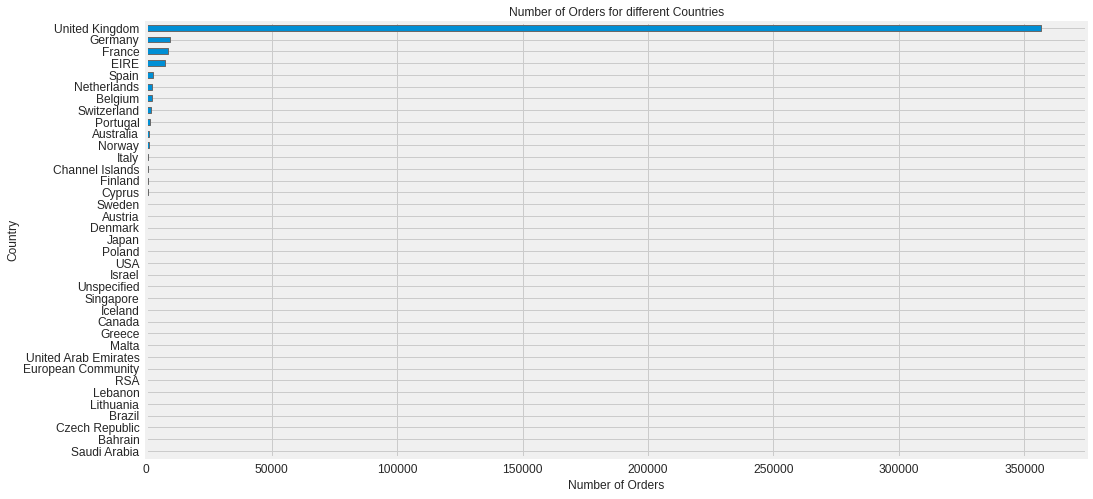

In [ ]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()

plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()


We see that UK stands out above the others so let's exclude it to better appreciate the graph

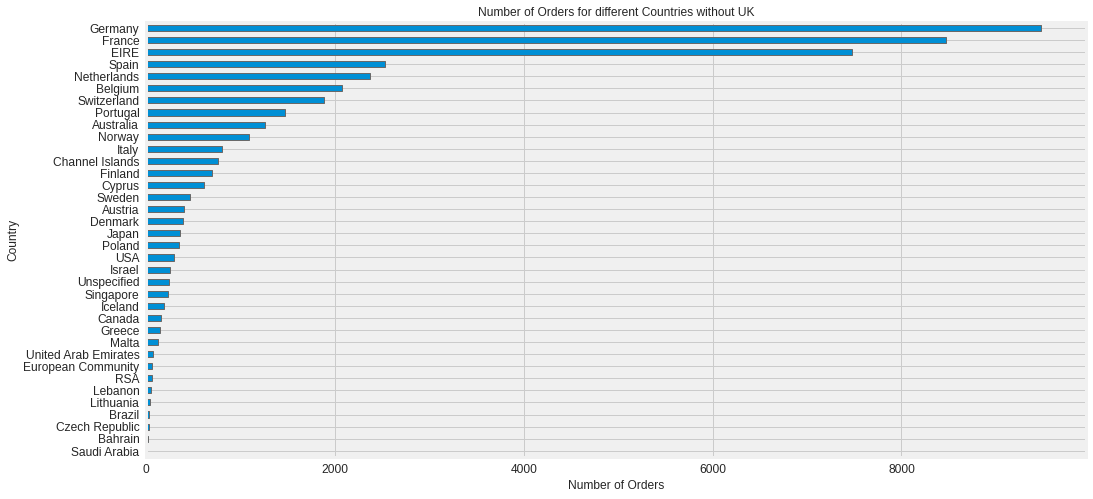

In [ ]:
group_country_orders = df.groupby('Country')['InvoiceNo'].count().sort_values()
del group_country_orders['United Kingdom']

plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries without UK', fontsize=12)
plt.show()

Country unitprice mean

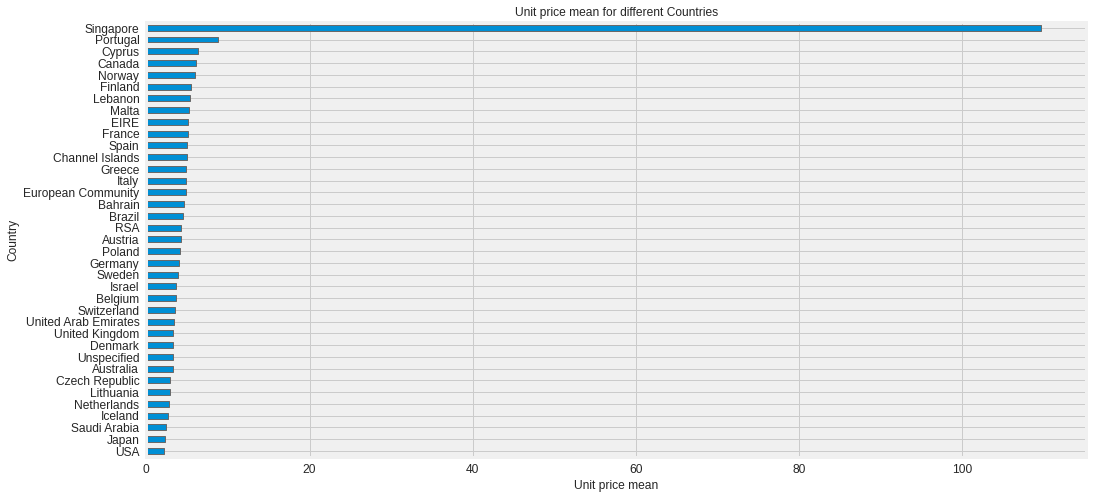

In [ ]:
group_country_orders = df.groupby('Country')['UnitPrice'].mean().sort_values()

plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Unit price mean', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Unit price mean for different Countries', fontsize=12)
plt.show()

We see that Singapour stands out above the others so let's exclude it to better appreciate the graph

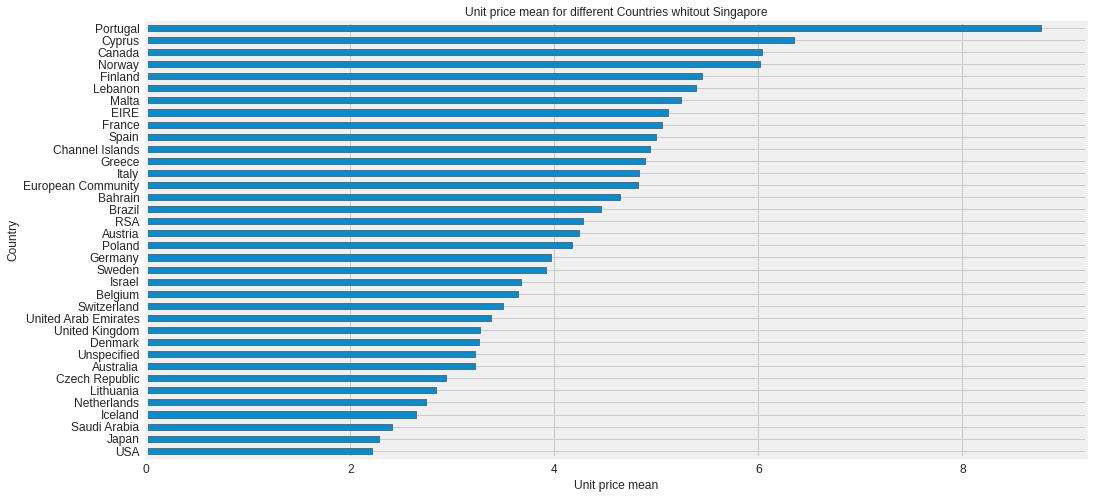

In [ ]:
group_country_orders = df.groupby('Country')['UnitPrice'].mean().sort_values()
del group_country_orders['Singapore']

plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12)
plt.xlabel('Unit price mean', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Unit price mean for different Countries whitout Singapore', fontsize=12)
plt.show()

##2.2 Customers and products

In [ ]:
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])

,Products,Transactions,Customers
Quantity,3684,22190,4372


A useful information would now be to find out the number of products purchased in every transaction.
We know that the InvoiceDate represents the day and time when each transaction was generated. So if we group by customerID and invoice number we can actually count the InvoiceDate as it gives us the number of different items bought by a client at a specific date.


In [ ]:
df1 = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
products_per_basket = df1.rename(columns = {'InvoiceDate':'Number of products'})
products_per_basket[:15].sort_values('CustomerID') #first 15 entries

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


###2.2.1 Cancelling orders

We know that the cancelled orders are signaled by a C in front of the InvoiceNo.

e.g: C536391.

In [ ]:
canceled_orders = df[df['InvoiceNo'].apply(lambda x: x[0]=='C')]
canceled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548,United Kingdom


In [ ]:
print('The percentage of canceled orders is: {} %'.format(round(canceled_orders.shape[0]/df.shape[0]*100,2)))

The percentage of canceled orders is: 2.21 %


Moreover, it looks like there are some discounts among the canceled orders.

In [ ]:
discounts = df[df['StockCode'].apply(lambda order: order=='D')]
discounts.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527,United Kingdom
9038,C537164,D,Discount,-1,12/5/2010 13:21,29.29,14527,United Kingdom
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.00,15498,United Kingdom
19392,C537857,D,Discount,-1,12/8/2010 16:00,267.12,17340,United Kingdom
31134,C538897,D,Discount,-1,12/15/2010 9:14,5.76,16422,United Kingdom


In [ ]:
discounts.shape

(77, 8)

The company issued 77 discounts.
We know have to check if there are other discounts in the original dataset.

In [ ]:
df[df['StockCode'].apply(lambda order: order=='D')].shape[0]

77

No, all the discounts are correctly included in the transactions with negative values so we will drop all the canceled orders.

In [ ]:
df = df[df['Quantity'] > 0]
df.sort_values(by='StockCode', ascending=False, inplace=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299512,563100,POST,POSTAGE,6,8/12/2011 9:57,40.0,12381,Norway
224432,556526,POST,POSTAGE,1,6/13/2011 11:33,18.0,12732,France
186640,552874,POST,POSTAGE,7,5/12/2011 9:40,18.0,12621,Germany
103055,545051,POST,POSTAGE,1,2/27/2011 11:58,18.0,12599,France
477044,577046,POST,POSTAGE,7,11/17/2011 13:46,18.0,12449,Belgium


###2.2.2 StockCode

Above, we have seen that some values of the StockCode variable indicate a particular transaction (i.e. D for Discount). We then check the contents of this variable by looking for the set of codes that would contain only letters (D value is now missing because we saw that discounts were included in transactions with negative values):

In [ ]:
list_special_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES'], dtype=object)

In [ ]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df[df['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
PADS            -> PADS TO MATCH ALL CUSHIONS    
M               -> Manual                        
DOT             -> DOTCOM POSTAGE                
C2              -> CARRIAGE                      
BANK CHARGES    -> Bank Charges                  


###2.2.3 Basket Price

We create a new variable that indicates the total price for every purchase:

In [ ]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity']
df.sort_values('CustomerID')[:5] # first 5 entries

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346,United Kingdom,77183.60
428996,573511,23308,SET OF 60 VINTAGE LEAF CAKE CASES,24,10/31/2011 12:25,0.55,12347,Iceland,13.20
72269,542237,22134,MINI LADLE LOVE HEART RED,12,1/26/2011 14:30,0.42,12347,Iceland,5.04
286624,562032,22374,AIRLINE BAG VINTAGE JET SET RED,4,8/2/2011 8:48,4.25,12347,Iceland,17.00
286637,562032,22423,REGENCY CAKESTAND 3 TIER,3,8/2/2011 8:48,12.75,12347,Iceland,38.25


Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. We collect all the purchases made during a single order to recover the total order price:

In [ ]:
df2 = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = df2.rename(columns = {'TotalPrice':'Basket Price'})

df['InvoiceDate_datetime'] = df['InvoiceDate'].astype('M') # we first convert to datetime and then to int (due to casting issues)
df['InvoiceDate_int'] = df['InvoiceDate_datetime'].astype('int64')
df2 = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()

df.drop('InvoiceDate_int', axis = 1, inplace = True)
df.drop('InvoiceDate_datetime', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(df2['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,77183.60,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


In order to have a global view of the type of order performed in this dataset, we determine how the purchases are divided according to total prices:

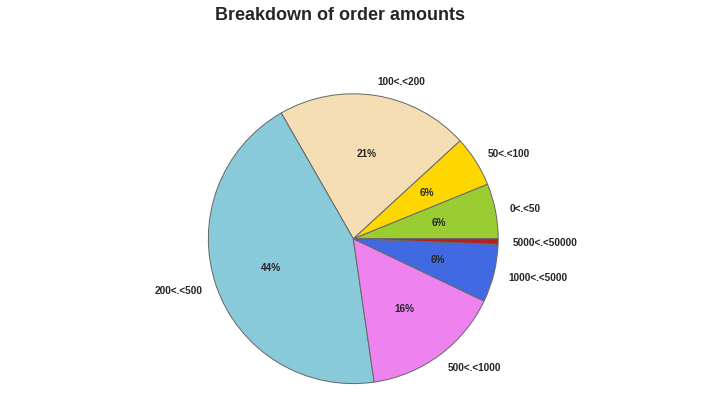

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Breakdown of order amounts", ha='center', fontsize = 18);

#3 Insight on product categories




> #### 3.1 Product description

In this section words frequency will be counted from product description, this aims to find which are the most used words. 
While dealing with text data a few prerequisites are needed:
1. Converting all words to lowecase
2. Removes 's
3. Remove punctuation and special characters
4. Expand contractions like he's to he is









In [ ]:
text_data = dfi[['Description']]
text_data['Description']

0          WHITE HANGING HEART T-LIGHT HOLDER
1                         WHITE METAL LANTERN
2              CREAM CUPID HEARTS COAT HANGER
3         KNITTED UNION FLAG HOT WATER BOTTLE
4              RED WOOLLY HOTTIE WHITE HEART.
                         ...                 
541904            PACK OF 20 SPACEBOY NAPKINS
541905           CHILDREN'S APRON DOLLY GIRL 
541906          CHILDRENS CUTLERY DOLLY GIRL 
541907        CHILDRENS CUTLERY CIRCUS PARADE
541908          BAKING SET 9 PIECE RETROSPOT 
Name: Description, Length: 541909, dtype: object

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
0          white hanging heart t-light holder
1                         white metal lantern
2              cream cupid hearts coat hanger
3         knitted union flag hot water bottle
4              red woolly hottie white heart.
                         ...                 
541904            pack of 20 spaceboy napkins
541905           children's apron dolly girl 
541906          childrens cutlery dolly girl 
541907        childrens cutlery circus parade
541908          baking set 9 piece retrospot 
Name: Description, Length: 406829, dtype: object


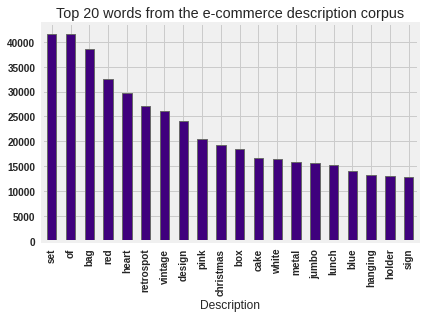

In [ ]:
import re

import math
import string
from typing import Dict, List, Tuple
from collections import Counter
import nltk
nltk.download('punkt')
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize

from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt     
from sklearn.feature_extraction.text import CountVectorizer
contractions_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

description_data = dfi
description_data = description_data.dropna()


def _lower_text(text_data: pd.DataFrame) -> pd.DataFrame:
    """Convert text to lower case"""
    text_data['Description'] = text_data['Description'].str.lower()
    return text_data


def _remove_text_paranthesis(text_data: pd.DataFrame) -> pd.DataFrame:
    """Removes the text inside paranthesis () and []"""
    p = re.compile(r'\([^)]*\)')
    text_data['Description'] = [p.sub('', x) for x in text_data['Description'].tolist()]
    return text_data


def _remove_s(text_data: pd.DataFrame) -> pd.DataFrame:
    """Removes 's"""
    p = re.compile(r"'s\b")
    text_data['Description'] = [p.sub('', x) for x in text_data['Description'].tolist()]
    return text_data


def _remove_punctuation(s):
    """Remove punctuation and special characters """
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s


def _expand_contactions(text_data1):
      """Expand contractions like he's to he is """
      text_data1 =' '.join([contractions_dict[i] if i in contractions_dict else i for i in text_data1.split()])
      return text_data1


def cleaning_pipeline(text_data: pd.DataFrame) -> pd.DataFrame:
    """Pipeline for cleaning the dataset"""
    text_data = _lower_text(text_data)
    print(text_data['Description'])
    text_data['Description'] = text_data['Description'].apply(_expand_contactions)
    text_data = _remove_s(text_data)
    text_data = _remove_text_paranthesis(text_data)
    text_data['Description'] = text_data['Description'].apply(_remove_punctuation)
    return text_data


def clean_tokens(text_data: pd.DataFrame) -> pd.DataFrame:
    """Tokenieze the already clean text """
    clean_tokens = []
    text_data = cleaning_pipeline(text_data)
    for j in text_data['Description']:
        for k in word_tokenize(j):
            clean_tokens.append(k)
    return clean_tokens


def __top_words(corpus, n=None):
    """For the next function"""
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def __common_words_plot():
    """Plot the most common 20 words from the e-commerce description corpus """
    common_words = __top_words(clean_tokens(description_data), 20)
    df1 = pd.DataFrame(common_words, columns = ['Description' , 'count'])
    df1.groupby('Description').sum()['count'].sort_values(ascending=False).plot(
                                                                            kind='bar',
                                                                            y='Count',
                                                                    colormap='Purples_r',
                            title='Top 20 words from the e-commerce description corpus')
    plt.savefig('commmon_words_clean.png')                           
    plt.show()



__common_words_plot()



#### 3.2 Defining product categories

An easy attept to make an attepmpt to cattegorize the products would be by looking at the stock codes to see if the similarity between codes leads to a similarity bewteen categories of products. <br> For example, bread starts with code 101 and folowd by other code (eg. 101222) and Croissant also starts 101 and other specific code (eg. 101402). For both products starting 101 we can say that bakery products would be a more general category for both product.

<br> <br>In the following examples we will try to see if the described aproach is applicable on our data

In [ ]:
unique_stock_code = df.StockCode.unique()
len(unique_stock_code)

3665

We have 3665 diferent products based on StockCode

For the data to be more vissible on a scatterplot, a counter for each stock code of the number of times it was bought will be added to the dataframe.

In [ ]:
count_for_each_code = df['StockCode'].value_counts().to_frame()

In [ ]:
def return_description_from_stockcode(code, aDataFrame):
  return aDataFrame.loc[aDataFrame['StockCode'] == str(code), 'Description'].values[0]
  

In [ ]:
for i in count_for_each_code.index:
  count_for_each_code.at[i, 'Description'] = return_description_from_stockcode(i, df)

In [ ]:
count_for_each_code_labeled = count_for_each_code

In [ ]:
count_for_each_code_labeled = count_for_each_code_labeled.reset_index(inplace = False)

In order to be able to represent the stock code on a graph because some stockcodes contain letters some other encoding need to be used. For the ones which contains letters, each letter will be transformed into ascii representation of digits and after added to the stock code number.

In [ ]:
def convertLettersToAsci(text):
    text = str(text)
    new_list = ''
    
    for i in range(len(text)):
        if (text[i].isalpha()):
            new_list = new_list + (str(ord(text[i])))
        else:
            new_list = new_list + (str(text[i]))

    ret = 0
    try:
      ret = int(new_list)
    except:
      print(new_list)
    #new_list.replace(" ","")
    return ret

In [ ]:
count_for_each_code_labeled = count_for_each_code_labeled.rename(columns ={'index':"StockCode", "StockCode":'Counter'} , inplace = False)
count_for_each_code_relabeled = count_for_each_code_labeled
count_for_each_code_relabeled['StockCode'] = count_for_each_code_relabeled['StockCode'].map(convertLettersToAsci)
count_for_each_code_relabeled

66657875 67726582716983


,StockCode,Counter,Description
0,8512365,2023,WHITE HANGING HEART T-LIGHT HOLDER
1,22423,1714,REGENCY CAKESTAND 3 TIER
2,8509966,1615,JUMBO BAG RED RETROSPOT
3,84879,1395,ASSORTED COLOUR BIRD ORNAMENT
4,47566,1390,PARTY BUNTING
...,...,...,...
3660,9002665,1,GLASS BEAD HOOP NECKLACE BLACK
3661,20703,1,BLUE PADDED SOFT MOBILE
3662,9013065,1,WHITE STONE/CRYSTAL EARRINGS
3663,9000165,1,ANTIQUE RASPBERRY FLOWER EARRINGS


In [ ]:
tmp_unique_stock_code = count_for_each_code_relabeled.StockCode.unique()
len(tmp_unique_stock_code)

3665

In [ ]:
count_for_each_code_relabeled['StockCode'] = pd.to_numeric(count_for_each_code_relabeled['StockCode'])

We plot the codes. (the counter is stil used just for visual purpose)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


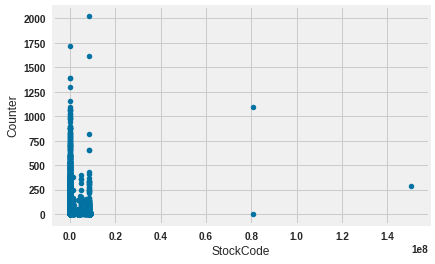

In [ ]:
count_for_each_code_relabeled.plot.scatter(x='StockCode', y='Counter')

In [ ]:
count_for_each_code_relabeled.sort_values(by=['StockCode'], ascending=False)

,StockCode,Counter,Description
340,150566676,291,EDWARDIAN PARASOL BLACK
7,80798384,1099,POSTAGE
3237,80656883,4,PADS TO MATCH ALL CUSHIONS
3572,9021490,1,"LETTER ""Z"" BLING KEY RING"
3315,9021489,3,"LETTER ""Y"" BLING KEY RING"
...,...,...,...
2440,10080,21,GROOVY CACTUS INFLATABLE
1810,10002,49,INFLATABLE POLITICAL GLOBE
927,672,133,CARRIAGE
354,77,285,Manual


Some outliers are eliminated

In [ ]:
count_for_each_code_relabeled = count_for_each_code_relabeled[count_for_each_code_relabeled.StockCode != 150566676	]
count_for_each_code_relabeled = count_for_each_code_relabeled[count_for_each_code_relabeled.StockCode != 80798384	]
count_for_each_code_relabeled = count_for_each_code_relabeled[count_for_each_code_relabeled.StockCode != 80656883	]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


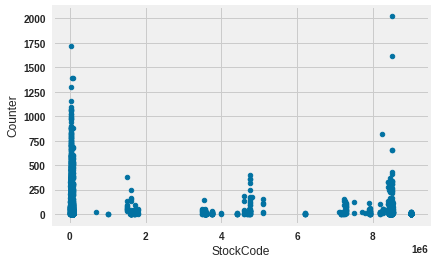

In [ ]:
count_for_each_code_relabeled.plot.scatter(x='StockCode', y='Counter')

In the scatterplot above it can be seen that there could be visually identified at least 4 clusters. <br>
Below we will try to do a "zoom" on each clusters to see if we can identify some cathegories by following the stock code and the actual description.

In [ ]:
block1 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 0) & (count_for_each_code_relabeled.StockCode < 20000)]
block2 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 20000) & (count_for_each_code_relabeled.StockCode < 30000)]
block3 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 30000) & (count_for_each_code_relabeled.StockCode < 60000)]
block4 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 60000) & (count_for_each_code_relabeled.StockCode < 80000)]
block5 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 80000) & (count_for_each_code_relabeled.StockCode < 100000)]
block6 = count_for_each_code_relabeled[ (count_for_each_code_relabeled.StockCode >= 100000) ]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


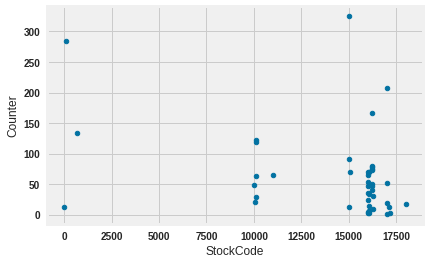

In [ ]:
block1.plot.scatter(x='StockCode', y='Counter')

We can see a lot of things in this first cluster that could fit into a office category, but there are still objects that did not fill the pattern.

In [ ]:
block1[:25].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
354,77,285,Manual
927,672,133,CARRIAGE
1810,10002,49,INFLATABLE POLITICAL GLOBE
1611,10125,63,MINI FUNKY DESIGN TAPES
1003,10133,122,COLOURING PENCILS BROWN TUBE
1028,10135,119,COLOURING PENCILS BROWN TUBE
1591,11001,64,ASSTD DESIGN RACING CAR PEN
1280,15034,91,PAPER POCKET TRAVELING FAN
276,15036,325,ASSORTED COLOURS SILK FAN
1514,15039,70,SANDALWOOD FAN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


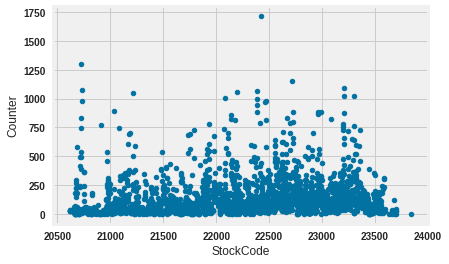

In [ ]:
block2.plot.scatter(x='StockCode', y='Counter')

Same here, very close data by stock code, but very far by descripion: <br> 1	22423	1714	REGENCY CAKESTAND 3 TIER <br> and <br> 19	22457	972	NATURAL SLATE HEART CHALKBOARD

In [ ]:
block2[:25].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
5,20725,1304,LUNCH BAG RED RETROSPOT
9,20727,1078,LUNCH BAG BLACK SKULL.
18,20728,977,LUNCH BAG CARS BLUE
21,21034,897,REX CASH+CARRY JUMBO SHOPPER
12,21212,1050,PACK OF 72 RETROSPOT CAKE CASES
15,22086,1003,PAPER CHAIN KIT 50'S CHRISTMAS
29,22138,858,BAKING SET 9 PIECE RETROSPOT
11,22197,1060,SMALL POPCORN HOLDER
16,22382,993,LUNCH BAG SPACEBOY DESIGN
10,22383,1063,LUNCH BAG SUKI DESIGN


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


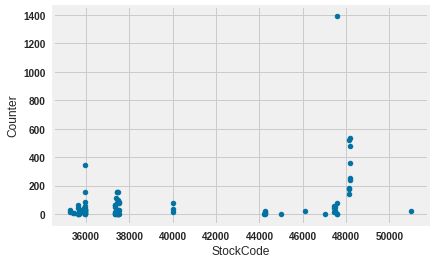

In [ ]:
block3.plot.scatter(x='StockCode', y='Counter')

In [ ]:
block3[:50].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
2200,35241,30,ENAMEL BLUE RIM BISCUIT BIN
1865,35646,46,VINTAGE BEAD PINK EVENING BAG
1601,35648,63,VINTAGE BEAD PINK PURSE
2113,35651,34,VINTAGE BEAD PINK SCARF
2536,35914,18,PINK CHICK EGG WARMER + EGG CUP
1957,35923,42,CANDY HEART HANGING DECORATION
2137,35924,33,HANGING FAIRY CAKE DECORATION
1312,35953,88,FOLKART STAR CHRISTMAS DECORATIONS
2136,35954,33,SMALL FOLKART STAR CHRISTMAS DEC
770,35961,157,FOLKART ZINC HEART CHRISTMAS DEC


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


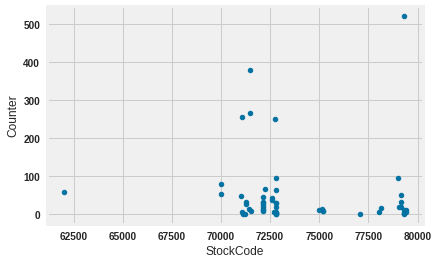

In [ ]:
block4.plot.scatter(x='StockCode', y='Counter')

In [ ]:
block4[:25].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
1661,62018,59,SOMBRERO
1386,70006,80,LOVE HEART POCKET WARMER
1732,70007,54,HI TEC ALPINE HAND WARMER
1841,71038,48,WHITE HANGING BEADS CANDLE HOLDER
415,71053,257,WHITE METAL LANTERN
2168,71270,32,PHOTO CLIP LINE
2255,71279,28,PINK GLASS CANDLEHOLDER
201,71459,380,HANGING JAM JAR T-LIGHT HOLDER
389,71477,266,COLOUR GLASS. STAR T-LIGHT HOLDER
1889,72122,45,COFFEE SCENT PILLAR CANDLE


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


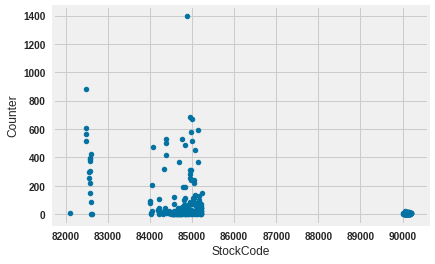

In [ ]:
block5.plot.scatter(x='StockCode', y='Counter')

In [ ]:
block5[:25].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
24,82482,882,WOODEN PICTURE FRAME WHITE FINISH
119,82483,512,WOOD 2 DRAWER CABINET WHITE FINISH
77,82484,604,WOOD BLACK BOARD ANT WHITE FINISH
94,82486,562,3 DRAWER ANTIQUE WHITE WOOD CABINET
194,82580,386,BATHROOM METAL SIGN
209,82582,376,AREA PATROLLED METAL SIGN
190,82583,392,HOT BATHS METAL SIGN
167,82600,422,NO SINGING METAL SIGN
139,84077,472,WORLD WAR 2 GLIDERS ASSTD DESIGNS
286,84347,320,ROTATING SILVER ANGELS T-LIGHT HLDR


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


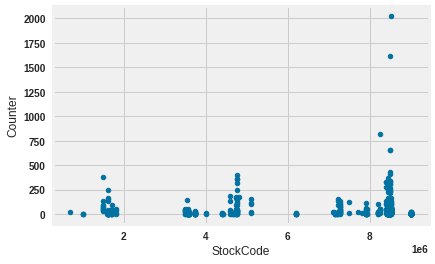

In [ ]:
block6.plot.scatter(x='StockCode', y='Counter')

In [ ]:
block6[:25].sort_values(by=['StockCode'], ascending=True)

,StockCode,Counter,Description
203,1505678,380,EDWARDIAN PARASOL NATURAL
441,1616180,248,WRAP ENGLISH ROSE
294,4756666,314,TEA TIME PARTY BUNTING
235,4759065,355,BLUE HAPPY BIRTHDAY BUNTING
224,4759066,360,PINK HAPPY BIRTHDAY BUNTING
185,4759168,397,PINK FAIRY CAKE CHILDRENS APRON
35,8249476,816,WOODEN FRAME ANTIQUE WHITE
282,8402969,323,RED WOOLLY HOTTIE WHITE HEART.
279,8402971,323,KNITTED UNION FLAG HOT WATER BOTTLE
367,8403069,279,ENGLISH ROSE HOT WATER BOTTLE


Also there could be seen that same type of products fit in more that one cluster: <br> 8459666	368	SMALL DOLLY MIX DESIGN ORANGE BOWL in Cluster 4 <br> 
<br> 37450	100	CERAMIC CAKE BOWL + HANGING CAKES 3 <br> 


The next attempt it would be too look at a way to cluster the product based on the text desctription.

In [ ]:
df.to_csv('new_data.csv')

#from google.colab import files
#files.download("new_data.csv")

#4 Customer categories

##4.1 Importing and formatting the new dataset which contains the categories for products

In [ ]:
new_df = pd.read_excel('/content/drive/MyDrive/data_with_product_categories.xlsx', dtype={'CustomerID': str,'InvoiceNo': str}, index_col=0)
new_df.head(15)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Label,NBLabel,GeneralCetegory,NbGeneralCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom,15.30,HANGING T-LIGHT,0,LIGHTS,0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,LANTERN HANGING,1,LIGHTS,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom,22.00,HANGER DOOR,2,HOUSEHOLD,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,BOTTLE WATER,3,HOUSEHOLD,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,OTHERS,4,OTHERS,2
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30,OTHERS,4,OTHERS,2
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50,T-LIGHT HOLDER,5,LIGHTS,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,WARMER HAND,6,OTHERS,2
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,WARMER HAND,6,OTHERS,2
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047,United Kingdom,54.08,COLOUR SILK,7,HOUSEHOLD,1


In [ ]:
for i in range(11):
    col = 'categ_{}'.format(i)        
    df_temp = new_df[new_df['NbGeneralCategory'] == i]
    price_temp = df_temp['UnitPrice'] * df_temp['Quantity']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    new_df.loc[:, col] = price_temp
    new_df[col].fillna(0, inplace = True)
new_df[['InvoiceNo', 'Description', 'NbGeneralCategory', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9', 'categ_10']][:5]

,InvoiceNo,Description,NbGeneralCategory,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.30,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.00,22.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.00,20.34,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.00,0.00,20.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = new_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

for i in range(11):
    col = 'categ_{}'.format(i) 
    temp = new_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 

new_df['InvoiceDate_datetime'] = new_df['InvoiceDate'].astype('M') # we first convert to datetime and then to int (due to casting issues)
new_df['InvoiceDate_int'] = new_df['InvoiceDate_datetime'].astype('int64')
temp = new_df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
new_df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,InvoiceDate
0,12346,541431,77183.60,0.00,77183.60,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,84.00,217.65,124.44,70.8,182.90,0.0,0.0,17.0,15.0,0.0,0.0,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,32.40,279.69,0.00,35.4,57.80,0.0,0.0,42.5,0.0,27.6,0.0,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,19.80,116.85,30.00,15.0,75.80,6.0,0.0,93.5,11.7,18.0,249.6,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,24.96,184.40,30.70,53.1,13.16,0.0,0.0,51.0,0.0,25.2,0.0,2011-06-09 13:01:00.000000256


The dataframe basket_price contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, we split the data set by using the first 10 months to train the model and the following two months to test it:

In [ ]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())


2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [ ]:
set1         = basket_price[pd.to_datetime(basket_price['InvoiceDate']).dt.date < datetime.date(2011,10,1)]
set2         = basket_price[pd.to_datetime(basket_price['InvoiceDate']).dt.date >= datetime.date(2011,10,1)]
basket_price = set1.copy(deep = True)

In a second step, we group together the different entries that correspond to the same user. We thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(11):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,12347,5,382.52,711.79,558.172000,2790.86,5.774564,37.369843,7.472249,11.125603,13.853078,0.214987,0.000000,11.752650,0.956694,2.536852,8.943480
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,33.664953,33.940932,9.681512,4.351116,0.000000,0.000000,0.000000,0.000000,0.000000,18.361488
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,25.478469,26.226077,0.000000,20.275120,2.541866,0.000000,4.485646,0.000000,20.992823,0.000000
4,12352,7,120.33,840.30,313.472857,2194.31,6.904220,24.832863,50.922613,3.556927,12.976744,0.000000,0.806632,0.000000,0.000000,0.000000,0.000000


Finally, we define two additional variables that give the number of days elapsed since the first purchase ( FirstPurchase ) and the number of days since the last purchase ( LastPurchase ):

In [ ]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,LastPurchase,FirstPurchase
0,12346,1,77183.60,77183.60,77183.600000,77183.60,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,255,255
1,12347,5,382.52,711.79,558.172000,2790.86,5.774564,37.369843,7.472249,11.125603,13.853078,0.214987,0.000000,11.752650,0.956694,2.536852,8.943480,59,297
2,12348,4,227.44,892.80,449.310000,1797.24,0.000000,33.664953,33.940932,9.681512,4.351116,0.000000,0.000000,0.000000,0.000000,0.000000,18.361488,5,288
3,12350,1,334.40,334.40,334.400000,334.40,0.000000,25.478469,26.226077,0.000000,20.275120,2.541866,0.000000,4.485646,0.000000,20.992823,0.000000,240,240
4,12352,7,120.33,840.30,313.472857,2194.31,6.904220,24.832863,50.922613,3.556927,12.976744,0.000000,0.806632,0.000000,0.000000,0.000000,0.000000,2,226


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them.

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Number of clients with an unique order: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

Number of clients with an unique order: 1445/3616  (39.96%)


## 4.2 Creating customer categories

### 4.2.1 Data encoding

The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. We use this information to characterize the different types of customers and only keep a subset of variables:

In [ ]:
list_cols = ['count','min','max','mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9', 'categ_10']
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables we selected have quite different ranges of variation and before continuing the analysis, we create a matrix where these values are standardized:

In [ ]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.64159292 283.80657135 598.26905227 406.80196824   7.22196134
  34.60361507  11.56603344   3.5607793   17.78640156   3.77004803
   5.75215359   7.96417612   3.44383051   3.37506632   0.95593471]


In the following, we will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the scaled_matrix matrix. In this case, we will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. We therefore perform a PCA beforehand:

In [ ]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

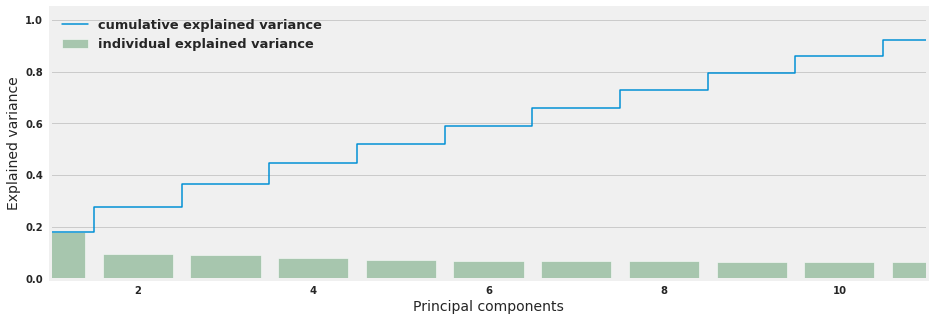

In [ ]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

### 4.2.2 Creation of customer categories

We now use the Elbow method to determine which would be our optimal k for kmeans clustering.

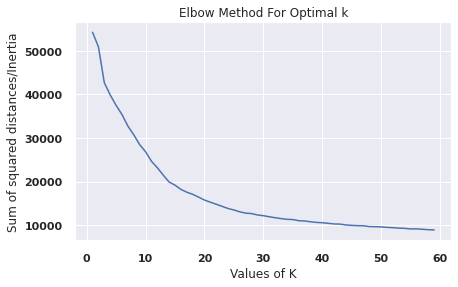

In [ ]:
Sum_of_squared_distances = []
K = range(1,60)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(pca_samples)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
n_clusters = 13
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.189


In [ ]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T


,5,0,1,3,8,11,10,6,12,2,7,9,4
nb. de clients,1353,1056,267,214,130,126,119,96,80,80,69,25,1


There is a certain disparity in the sizes of different groups that have been created. Hence we will now try to understand the content of these clusters in order to validate (or not) this particular separation. We can use the result of the PCA:

In [ ]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

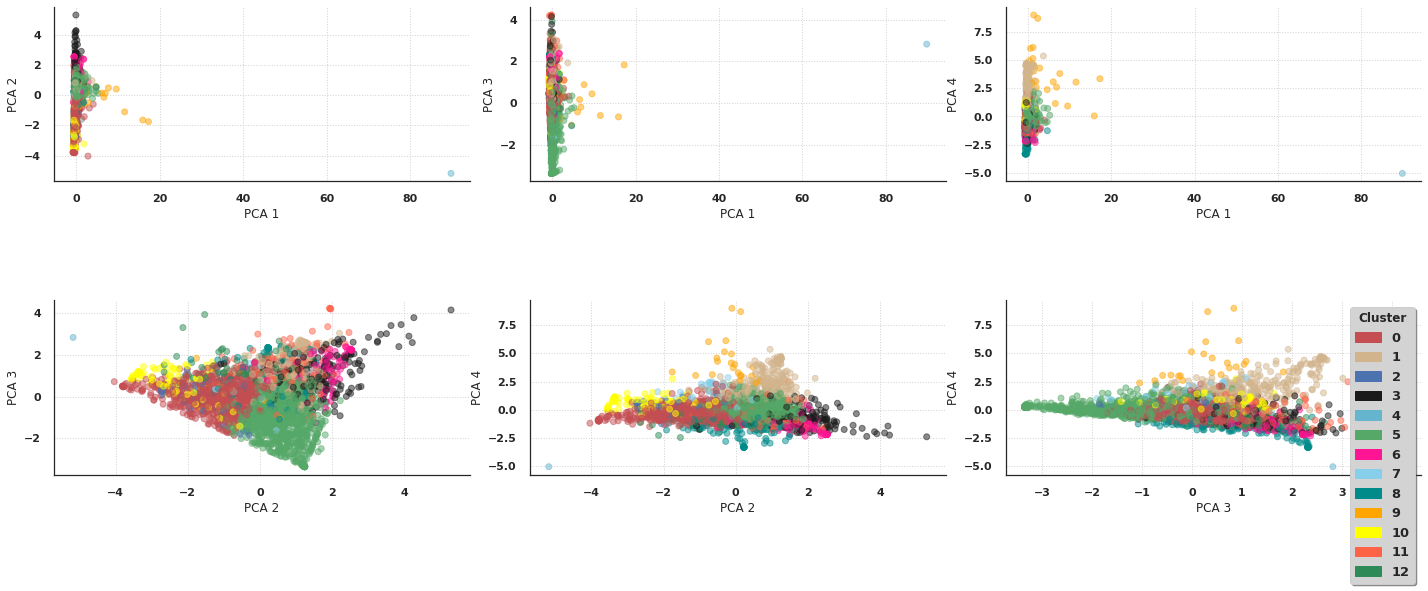

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (20,15))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c=label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

We add to the selected_customers dataframe a variable that defines the cluster to which each client belongs. Then, we average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. We also determine the number of clients in each group (in the variable 'size').

In [ ]:
selected_customers.loc[:, 'cluster'] = clusters_clients

merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3616


In [ ]:
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9', 'categ_10', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10,size
0,12.0,2.012500,262.256625,357.152625,304.086546,549.184375,4.804063,23.972943,10.381582,2.878413,17.501904,3.198715,4.292671,3.629570,2.928453,4.343618,22.068067,80
1,11.0,2.206349,264.556984,387.323651,320.513402,637.304762,3.773661,23.102163,11.659147,3.026857,12.930713,2.733739,5.337881,6.104923,2.196835,28.449347,0.684733,126
2,7.0,2.347826,188.383768,367.942899,261.751249,713.265362,3.438759,20.116921,5.706535,1.621144,7.187185,2.158208,1.515092,2.831048,53.962644,0.693421,0.769042,69
3,8.0,1.984615,321.513077,456.207846,376.808188,725.958308,4.907955,23.398534,10.612554,1.777677,10.965365,1.374776,41.536352,2.250787,1.229046,1.523976,0.422979,130
4,2.0,2.525000,219.798125,381.470625,293.537065,785.914500,3.765024,19.371439,4.752531,0.981395,16.005932,45.774829,3.261956,2.163151,1.242115,2.619409,0.062220,80
5,10.0,2.789916,181.623782,299.006134,229.675500,789.133613,64.883460,14.532606,3.823750,0.318250,8.945035,0.971321,3.568965,0.964603,0.930197,0.775953,0.285860,119
6,3.0,2.345794,323.216963,517.751869,410.301533,956.541963,2.843445,26.923629,14.626830,24.470146,10.501590,1.835739,5.804378,7.077733,1.778003,3.672438,0.466068,214
7,6.0,2.635417,270.575729,534.551458,371.082378,1174.025937,1.854245,14.814137,65.651573,1.608329,6.529733,1.292687,2.823199,2.396310,1.917767,0.943929,0.168089,96
8,0.0,3.520833,234.805048,459.135607,333.084979,1178.308922,8.552921,26.495321,9.347799,1.800131,34.748709,3.783482,5.088412,4.078679,3.017649,2.470615,0.616282,1056
9,5.0,3.561715,279.646497,598.105027,416.369541,1556.713409,4.072666,52.931169,11.415681,2.768627,11.025074,2.916952,4.320537,4.885999,2.589231,2.669857,0.404206,1353


#5 Classifying customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in scikit-learn. We define a class that allows to interface several of the functionalities common to these different classifiers:

In [ ]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, we only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time.

In [ ]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 'categ_6', 'categ_7', 'categ_8', 'categ_9', 'categ_10']
X = selected_customers[columns]
Y = selected_customers['cluster']

In [ ]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

##5.1 Support Vector Machine Classifier (SVC)
The first classifier we use is the SVC classifier. In order to use it, we create an instance of the Class_Fit class and then callgrid_search(). When calling this method, we provide as parameters:

- the hyperparameters for which we will seek an optimal value
- the number of folds to be used for cross-validation

In [ ]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [ ]:
#Once this instance is created, I adjust the classifier to the training data:
svc.grid_fit(X = X_train, Y = Y_train)

#then I can test the quality of the prediction with respect to the test data:
svc.grid_predict(X_test, Y_test)

Precision: 86.19 % 


###5.1.1 Confusion matrix


Confusion matrix, without normalization


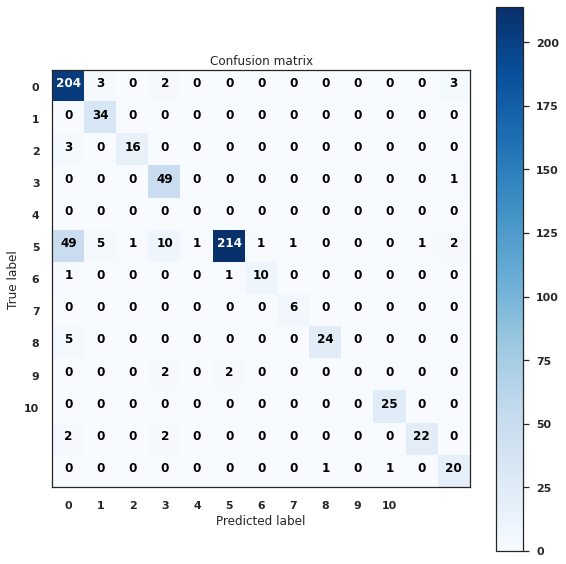

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

###5.1.2 Learning curve
A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over-fitting or under-fitting. This also shows to which extent the model could benefit from a larger data sample.

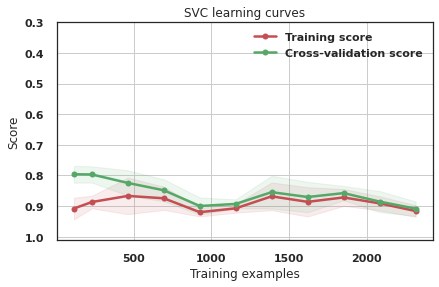

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.3],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

##5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:



In [ ]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 82.32 % 


##5.3 k-Nearest Neighbors

In [ ]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 73.48 % 


##5.4 Decision Tree

In [ ]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 89.36 % 


##5.5 Random Forest

In [ ]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 95.86 % 


###5.5.1 Confusion Matrix

Confusion matrix, without normalization


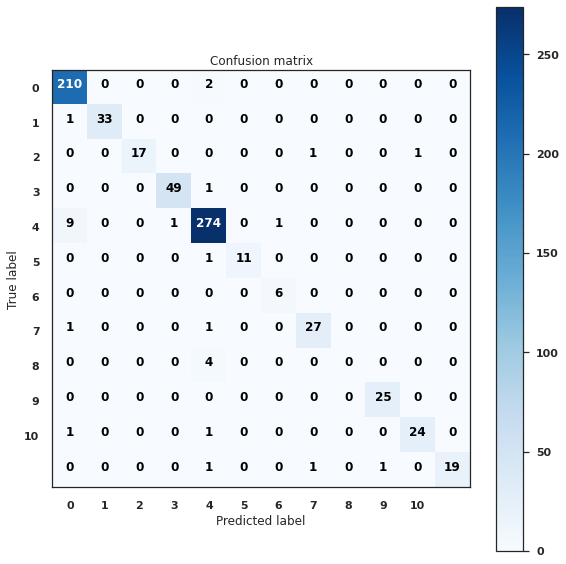

In [ ]:
class_names = [i for i in range(11)]
rf_matrix = confusion_matrix(Y_test, rf.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(rf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

### 5.5.2 Learning Curve

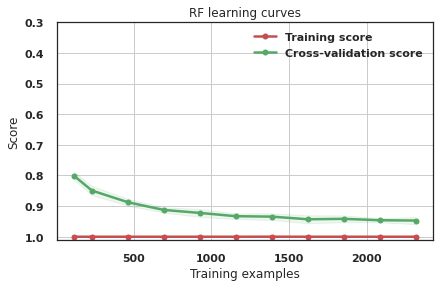

In [ ]:
g = plot_learning_curve(rf.grid.best_estimator_,
                        "RF learning curves", X_train, Y_train, ylim = [1.01, 0.3],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

##5.6 AdaBoost Classifier

In [ ]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 62.02 % 


###5.6.1 Confusion Matrix

Confusion matrix, without normalization


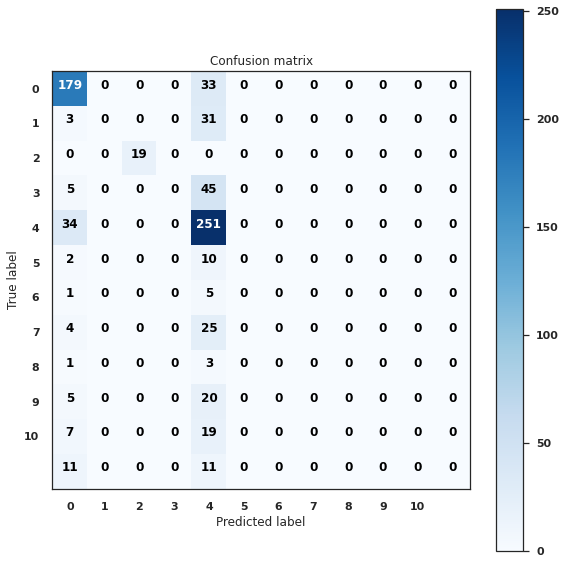

In [ ]:
class_names = [i for i in range(11)]
ada_matrix = confusion_matrix(Y_test, ada.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(ada_matrix, classes=class_names, normalize = False, title='Confusion matrix')

###5.6.2 Learning Curve

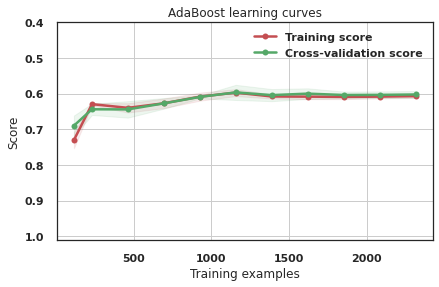

In [ ]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

##5.7 Gradient Boosting Classifier

In [ ]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 94.48 % 


###5.7.1 Confusion Matrix

Confusion matrix, without normalization


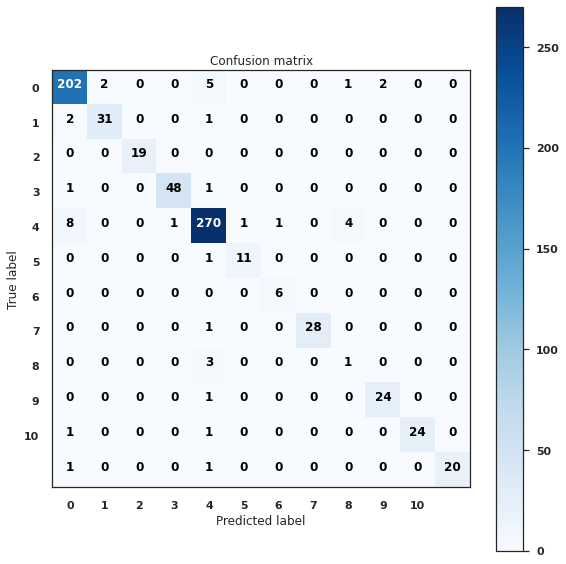

In [ ]:
class_names = [i for i in range(11)]
gb_matrix = confusion_matrix(Y_test, gb.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(gb_matrix, classes=class_names, normalize = False, title='Confusion matrix')

###5.7.2 Learning Curve

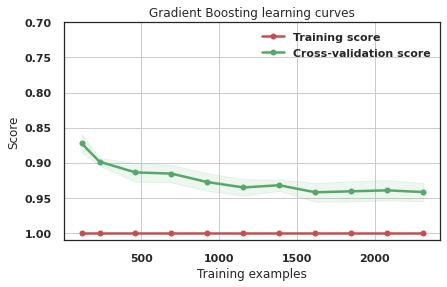

In [ ]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#6 Testing the predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first $10$ months. In this section, I test the model the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [ ]:
basket_price_pred = set2.copy(deep = True)

In a first step, I perform a grouping process of these data according to the same procedure as used on the training set:

In [ ]:
transactions_per_user=basket_price_pred.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(11):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price_pred.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
#transactions_per_user['count'] = 5 * transactions_per_user['count']
#transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']
transactions_per_user = transactions_per_user.dropna()
transactions_per_user.sort_values('CustomerID', ascending = True)

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10
0,12347,2,224.82,1294.32,759.570000,1519.14,10.608634,68.653317,13.727504,20.439196,25.449926,0.394960,0.000000,21.591163,1.757573,4.660532,16.430349
2,12352,1,311.73,311.73,311.730000,311.73,48.599750,174.801912,358.451224,25.037693,91.345074,0.000000,5.677991,0.000000,0.000000,0.000000,0.000000
3,12356,1,58.35,58.35,58.350000,58.35,0.000000,2985.158526,854.498715,59.640103,523.598972,85.689803,173.984576,0.000000,0.000000,35.646958,0.000000
5,12358,1,683.20,683.20,683.200000,683.20,0.000000,15.260539,11.709602,0.000000,2.195550,0.000000,0.000000,0.000000,41.803279,0.000000,0.000000
6,12359,1,2814.30,2814.30,2814.300000,2814.30,0.000000,44.904950,12.154710,3.338308,9.574317,36.419358,1.177913,5.621291,6.598444,4.423835,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2552,18272,2,367.88,604.25,486.065000,972.13,6.079434,153.935173,24.976083,0.000000,31.693292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2553,18273,1,51.00,51.00,51.000000,51.00,0.000000,0.000000,0.000000,0.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2557,18282,1,77.84,77.84,77.840000,77.84,0.000000,112.358684,0.000000,0.000000,0.000000,16.379753,0.000000,0.000000,0.000000,0.000000,0.000000
2558,18283,6,1.95,307.05,159.783333,958.70,5.851674,28.072390,8.130802,4.422656,10.022948,0.000000,3.518306,44.782518,1.037864,7.525816,0.000000


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4','categ_5','categ_6','categ_7','categ_8','categ_9','categ_10']
matrix_test = transactions_per_user[list_cols].to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of $2$ months (via the variables `count` , `min` , `max` and `sum` ). The classifier defined in Section $5$ uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the kmeans method used in section $4$. The predict method of this instance calculates the distance of the consumers from the centroids of the $11$ client classes and the smallest distance will define the belonging to the different categories:

In [ ]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [ ]:
columns = ['mean','categ_0','categ_1','categ_2','categ_3','categ_4','categ_5','categ_6','categ_7','categ_8','categ_9','categ_10']
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [ ]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logistic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]

for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 68.82 % 
______________________________ 
Logistic Regression
Precision: 71.71 % 
______________________________ 
k-Nearest Neighbors
Precision: 63.33 % 
______________________________ 
Decision Tree
Precision: 49.89 % 
______________________________ 
Random Forest
Precision: 62.89 % 
______________________________ 
Gradient Boosting
Precision: 61.86 % 


In [ ]:
from pycaret.classification import *
from pycaret.utils import check_metric

In [ ]:
cols_to_drop = ['InvoiceDate']
basket_price_df = basket_price.drop(cols_to_drop, axis=1)
basket_price_df

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,categ_6,categ_7,categ_8,categ_9,categ_10
0,12346,541431,77183.60,0.00,77183.60,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0
1,12347,537626,711.79,84.00,217.65,124.44,70.80,182.90,0.0,0.00,17.00,15.0,0.00,0.0
2,12347,542237,475.39,32.40,279.69,0.00,35.40,57.80,0.0,0.00,42.50,0.0,27.60,0.0
3,12347,549222,636.25,19.80,116.85,30.00,15.00,75.80,6.0,0.00,93.50,11.7,18.00,249.6
4,12347,556201,382.52,24.96,184.40,30.70,53.10,13.16,0.0,0.00,51.00,0.0,25.20,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18283,557956,192.80,5.90,31.16,19.15,3.90,3.35,0.0,10.08,94.31,0.0,24.95,0.0
18524,18283,560025,137.39,11.10,41.98,17.90,4.55,3.40,0.0,1.65,46.66,0.0,10.15,0.0
18525,18283,560032,2.50,0.00,2.50,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.0
18526,18283,565579,134.90,0.00,21.23,8.95,4.95,9.20,0.0,10.20,80.37,0.0,0.00,0.0


#7 Conclusions

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately $∼ 4000$ clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into $5$ main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of $10$ months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the $10$ months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these $11$ categories and this from their first purchase. For this, the classifier is based on $5$ variables which are:

* `mean ` - amount of the basket of the current purchase
* `categ_N` with  $n∈[0,4]$ : percentage spent in product category with index  N


Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (over the $2$ months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that $75%$ of clients are awarded the right classes. The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas). In practice, this seasonal effect may cause the categories defined over a $10$-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.